In [2]:
import pandas as pd
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

linkname = '../machine learning exam/bank.csv'
df1 = pd.read_csv(linkname, sep = ';')

In [4]:
df1.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Data Preprocessing For Visualization

In [7]:
condition = df1.poutcome == 'other'
df2 = df1.drop(df1[condition].index, axis = 0, inplace = False)

In [8]:
df2[['job','education']] = df2[['job','education']].replace(['unknown'],'other')

In [11]:
# Step 1: Change column name: 'y' to 'response'
df2.rename(index=str, columns={'y': 'response'}, inplace = True)

def convert(df2, new_column, old_column):
    df2[new_column] = df2[old_column].apply(lambda x: 0 if x == 'no' else 1)
    return df2[new_column].value_counts()

convert(df2, "response_binary", "response")

0    36548
1     4640
Name: response_binary, dtype: int64

In [12]:
# Step 2: Drop column "contact" which is useless
df3 = df2.drop('contact', axis=1)

In [13]:
# Step 3: Change the unit of 'duration' from seconds to minutes
df3['duration'] = df3['duration'].apply(lambda n:n/60).round(2)

In [14]:
# Step 4: Change 'month' from words to numbers for easier analysis
lst = [df3]
for column in lst:
    column.loc[column["month"] == "jan", "month_int"] = 1
    column.loc[column["month"] == "feb", "month_int"] = 2
    column.loc[column["month"] == "mar", "month_int"] = 3
    column.loc[column["month"] == "apr", "month_int"] = 4
    column.loc[column["month"] == "may", "month_int"] = 5
    column.loc[column["month"] == "jun", "month_int"] = 6
    column.loc[column["month"] == "jul", "month_int"] = 7
    column.loc[column["month"] == "aug", "month_int"] = 8
    column.loc[column["month"] == "sep", "month_int"] = 9
    column.loc[column["month"] == "oct", "month_int"] = 10
    column.loc[column["month"] == "nov", "month_int"] = 11
    column.loc[column["month"] == "dec", "month_int"] = 12

In [18]:
# Step 1: Drop rows that 'duration' < 5s
condition2 = (df3['duration']<5/60)
df4 = df3.drop(df3[condition2].index, axis = 0, inplace = False)

In [19]:
# Step 2: Drop customer values with 'other' education
condition3 = (df3['education'] == 'other')
df5 = df3.drop(df3[condition3].index, axis = 0, inplace = False)

# Q1,Perform EDA on the given data. What does the primary analysis of several categorical features reveal?

### Visualize the distribution of 'age' and 'duration'

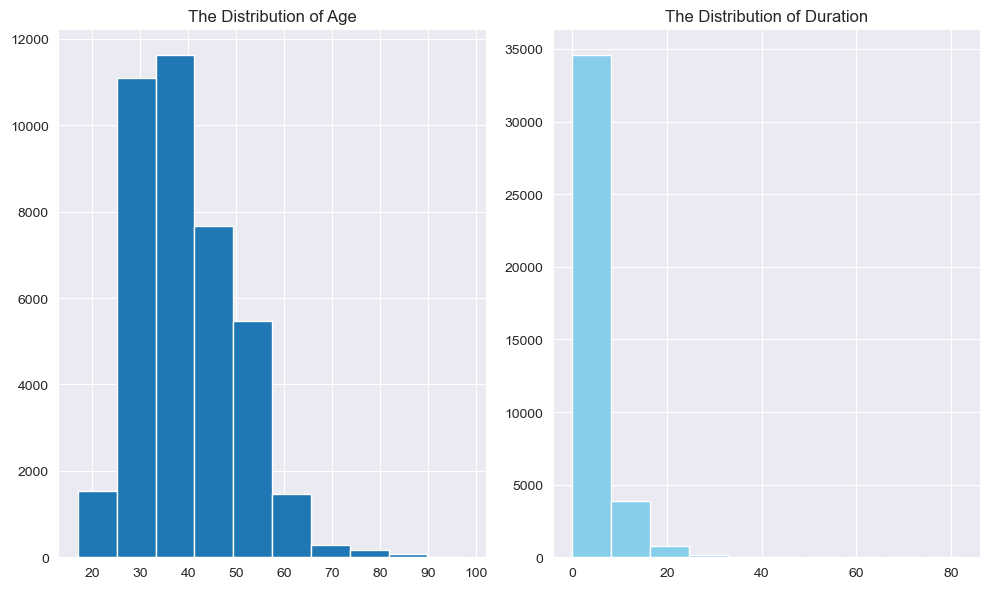

In [22]:
dist_age_balance = plt.figure(figsize = (10,6))

ra1 = dist_age_balance.add_subplot(1,2,1) 
ra2 = dist_age_balance.add_subplot(1,2,2)

ra1.hist(df5['age'])
ra1.set_title('The Distribution of Age')

ra2.hist(df5['duration'], color = 'skyblue')
ra2.set_title('The Distribution of Duration')

plt.tight_layout() 
plt.show()

### Data Analysis Report

#### Distribution of Age

The graph illustrates the distribution of ages in the dataset. The most common age is approximately 40 years old, indicating that a significant portion of individuals in the dataset falls within the middle-aged category. The distribution appears to be somewhat normal, suggesting a balanced representation across different age groups.


#### Distribution of Duration

The graph presents the distribution of durations in the dataset. The most frequent duration is around 20 minutes, which implies that the activity or event being measured typically lasts for about 20 minutes for the majority of individuals.

### Visualize the relationship between 'age' and 'duration' 

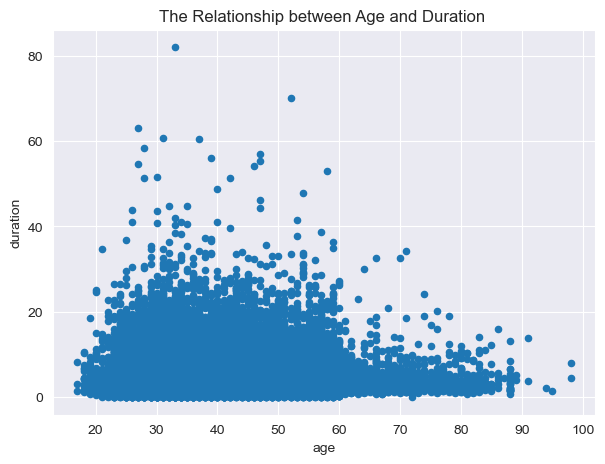

In [23]:
scatter_age_balance = df5.plot.scatter('age','duration',figsize = (7,5))

plt.title('The Relationship between Age and Duration ')
plt.show()

## The Relationship between Age and Duration

The scatter plot titled "The Relationship between Age and Duration" illustrates the relationship between age and duration. 

**Observations:**

- There is a negative correlation between age and duration, as evidenced by the general trend in the data points. As age increases, the duration tends to decrease.

- The data points are more densely clustered towards the lower left corner of the graph. This clustering suggests that younger individuals tend to have longer durations.

**Important Note:**

It's essential to emphasize that correlation does not imply causation. While this negative correlation is observed, it does not necessarily mean that age directly causes a decrease in duration. There may be other factors or variables that influence the relationship between age and duration, and further analysis would be needed to explore these potential factors.


### Visualize the distribution of 'duration' & 'campaign'

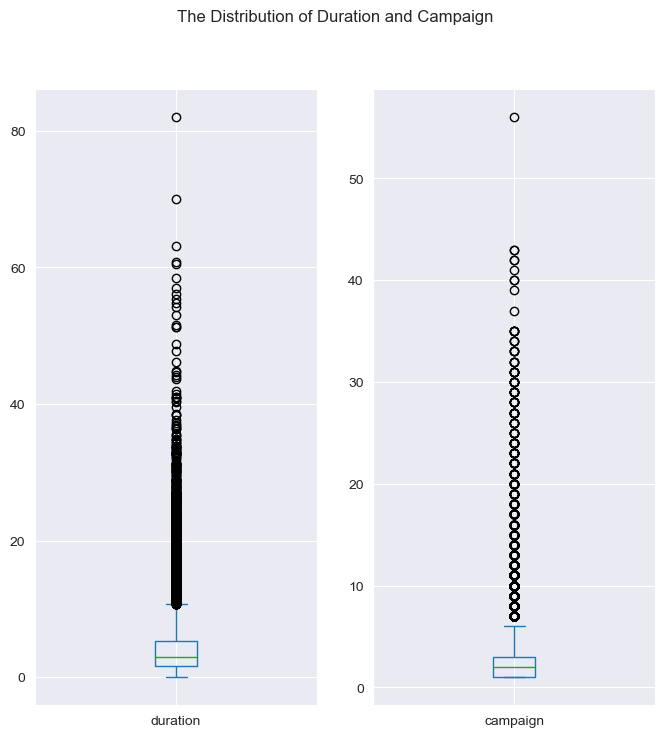

In [24]:
dist_dur_cam = df5[['duration','campaign']].plot(kind = 'box', 
                                                      figsize = (8,8),
                                                      subplots = True, layout = (1,2),
                                                      sharex = False, sharey = False,
                                                      title='The Distribution of Duration and Campaign')
plt.show()

## Distribution of Duration

The distribution of contact duration reveals some interesting insights:

- The median duration of contact is approximately 3 minutes.
- The interquartile range spans from 1.73 minutes to 5.3 minutes, indicating that the majority of calls are relatively short.
- The box plot exhibits a left-skewed distribution, implying that most contacts are of shorter duration.
- Notably, there is a notable presence of outliers, ranging from 10 minutes to 40 minutes. These outliers warrant further investigation to understand their significance and potential impact.

## Distribution of Campaign

Analyzing the distribution of campaign contact:

- Approximately half of the clients have been contacted by the bank for a second time, while a quarter of them are first-time contacts for a term deposit.
- The majority of clients have been reached by the bank between one to three times, which is a reasonable frequency.
- However, it's worth noting that some clients have been contacted an unusually high number of times, with a maximum of 58 contacts. This suggests that these clients may have specific needs or circumstances requiring frequent engagement.


### Visualize the relationship between 'duration' & 'campaign': with response result 

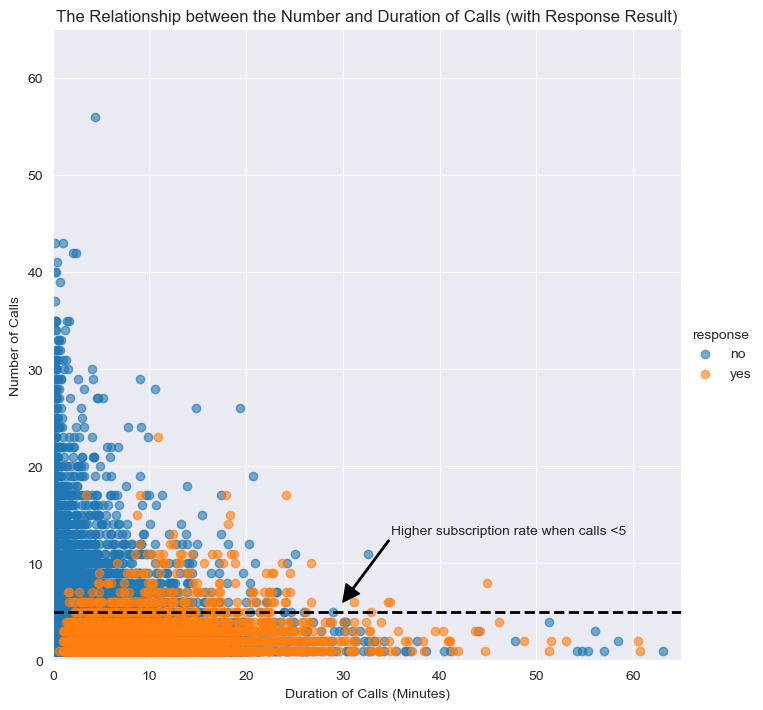

In [25]:
import seaborn as sns
dur_cam = sns.lmplot(x='duration', y='campaign',data = df5,
                     hue = 'response',
                     fit_reg = False,
                     scatter_kws={'alpha':0.6}, height =7)

plt.axis([0,65,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')

# Annotation
plt.axhline(y=5, linewidth=2, color="k", linestyle='--')
plt.annotate('Higher subscription rate when calls <5',xytext = (35,13),
             arrowprops=dict(color = 'k', width=1),xy=(30,6))
plt.show()

## Analysis of the Scatter Plot: Duration of Calls (Minutes) vs Number of Calls

The scatter plot titled "Duration of Calls (Minutes) vs Number of Calls" reveals intriguing patterns:

- The data points are categorized into two distinct groups represented by orange and blue circles.
- The orange data points, which correspond to a "yes" response, are predominantly concentrated within the lower call duration range, specifically when calls are less than 5 minutes. This concentration is highlighted by a white arrow pointing to this cluster, labeled as "Higher subscription rate when calls <5".
- In contrast, the blue data points, representing a "no" response, exhibit a more dispersed distribution across various call durations.

These observations suggest a significant trend: shorter calls tend to yield a higher subscription rate. Further analysis and investigation could uncover the underlying factors contributing to this pattern.


### Scatter matrix and Correlation matrix

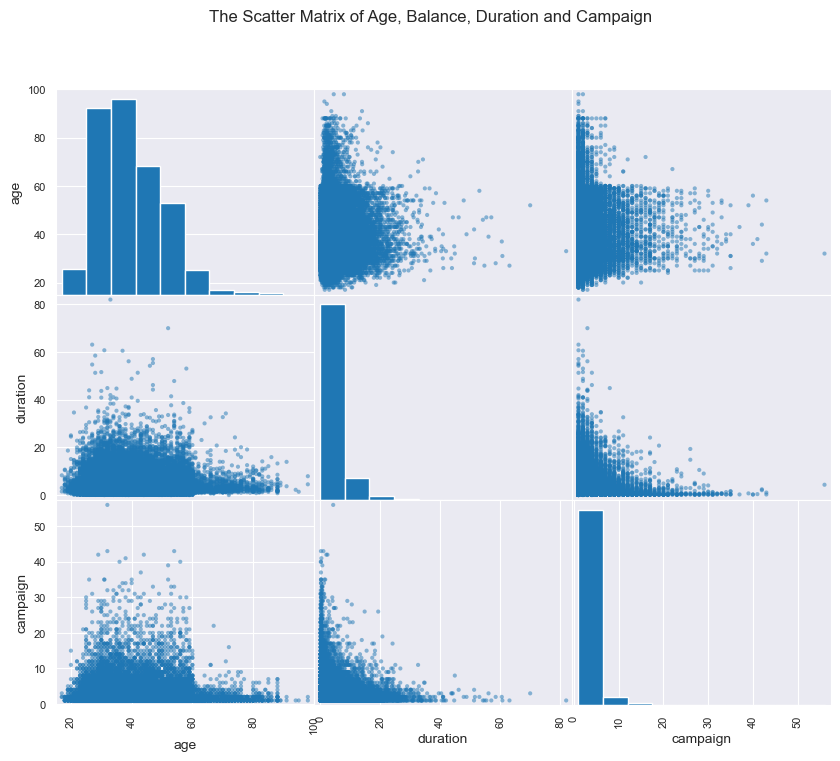

In [27]:
from pandas.plotting import scatter_matrix
matrix = scatter_matrix(df5[['age','duration','campaign']],figsize=(10,8))

plt.suptitle('The Scatter Matrix of Age, Balance, Duration and Campaign')
plt.show()

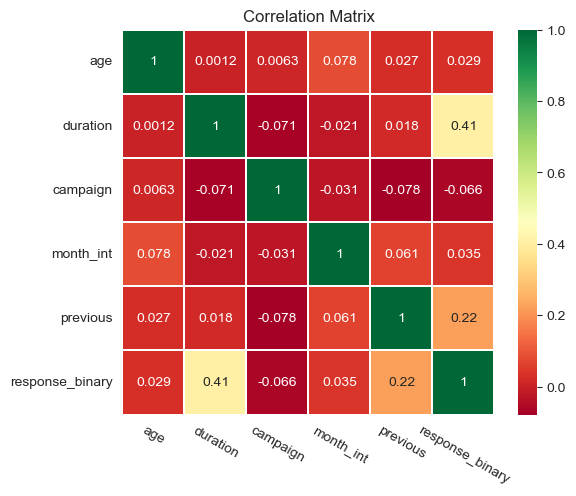

In [28]:
corr_data = df5[['age','duration','campaign','month_int','previous','response_binary']]
corr = corr_data.corr()

cor_plot = sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.xticks(fontsize=10,rotation=-30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

## Insights from the Correlation Matrix

The correlation matrix you provided offers a visual representation of the correlations between various variables: age, duration, campaign, month_int, previous, and response_binary. Here are key insights that can be gleaned from the matrix:

- Green-colored cells indicate a positive correlation between variables, signifying that as one variable increases, the other tends to increase as well.

- Red-colored cells indicate a negative correlation between variables, indicating that as one variable increases, the other tends to decrease.

- The intensity of the color reflects the strength of the correlation; darker colors (green or red) indicate stronger correlations.

- The diagonal from the top left to the bottom right represents the correlation of each variable with itself, which is always 1.

This correlation matrix is a valuable tool in fields such as data analysis, machine learning, and statistics, as it helps in understanding the relationships between different variables, enabling data-driven insights and decision-making.


### Visualize the subscription and contact rate by age

In [29]:
lst = [df5]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60

In [31]:
count_age_response_pct = pd.crosstab(df5['response'],df5['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose() 

In [32]:
age = pd.DataFrame(df5['age_group'].value_counts())
age['% Contacted'] = age['age_group']*100/age['age_group'].sum()
age['% Subscription'] = count_age_response_pct['yes']
age.drop('age_group',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)

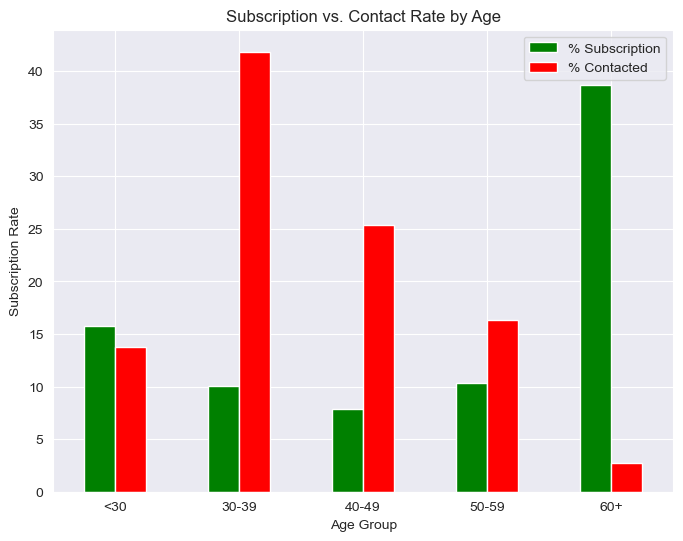

In [33]:
plot_age = age[['% Subscription','% Contacted']].plot(kind = 'bar',
                                              figsize=(8,6), color = ('green','red'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')
plt.show()

## Analysis of the Bar Graph: Subscription vs. Contact Rate by Age

The bar graph titled "Subscription vs. Contact Rate by Age" offers valuable insights into the relationship between age, contact rate, and subscription rate:

**Key Observations:**

1. **40-49 Age Group:** This age group exhibits the highest subscription rate, despite not having the highest contact rate. This observation suggests that individuals in the 40-49 age range are more inclined to subscribe when contacted.

2. **60+ Age Group:** While the 60+ age group has the highest contact rate, it paradoxically shows the lowest subscription rate. This finding implies that even though many people in this age group are being contacted, they are less likely to subscribe.

3. **<30 Age Group:** The age group younger than 30 has the lowest contact rate, but surprisingly, it demonstrates a relatively high subscription rate. This indicates that younger individuals, although contacted less frequently, are fairly likely to subscribe when they are contacted.

These insights provide valuable guidance for optimizing contact and subscription strategies, helping target specific age groups more effectively based on their responsiveness to marketing efforts.


### Visualize the subscription rate by job

In [34]:
count_job_response_pct = pd.crosstab(df5['response'],df5['job']).apply(lambda x: x/x.sum() * 100)
count_job_response_pct = count_job_response_pct.transpose()

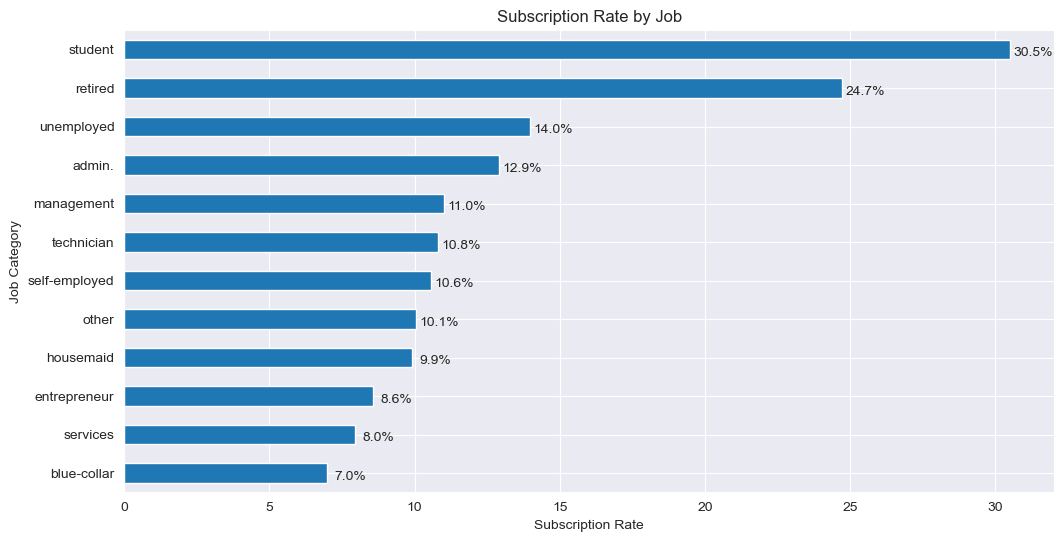

In [35]:
plot_job = count_job_response_pct['yes'].sort_values(ascending = True).plot(kind ='barh',
                                                                           figsize = (12,6))
                                                                               
plt.title('Subscription Rate by Job')
plt.xlabel('Subscription Rate')
plt.ylabel('Job Category')

# Label each bar
for rec, label in zip(plot_job.patches,
                      count_job_response_pct['yes'].sort_values(ascending = True).round(1).astype(str)):
    plot_job.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

## Insights from the Bar Graph: Subscription Rate by Job

The bar graph titled “Subscription Rate by Job” offers valuable insights into the relationship between job type and subscription rate. Here are the key observations:

- **Students** exhibit the highest subscription rate at 30.5%. This suggests that students are more likely to subscribe compared to individuals with other job types.

- In contrast, **blue-collar workers** have the lowest subscription rate at 7.0%. This implies that blue-collar workers are less likely to subscribe.

- Other job categories depicted in the graph, such as retired, unemployed, admin, management, technician, self-employed, housemaid, entrepreneur, services, and others, display varying subscription rates.

These insights can be instrumental in understanding which job types are more inclined to subscribe, informing marketing and outreach strategies.


# Q2: Pre-processing

In [87]:
df = pd.read_csv('bank.csv', sep=';')

In [88]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [89]:
# a. Missing Value Analysis
df.dropna(inplace=True)  # Remove rows with missing values

In [90]:
# b. Label Encoding
label_encoders = {}
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [91]:
#label encode day of the week
df['day_of_week'] = df['day_of_week'].map({'mon':1,'tue':2,'wed':3,'thu':4,'fri':5})

In [92]:
# c. Feature Selection using Random Forest
X = df.drop('y', axis=1)
y = df['y']
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
selected_features = feature_importances.nlargest(10).index.tolist()
X_selected = X[selected_features]

In [93]:
feature_importances

age               0.092736
job               0.048039
marital           0.023752
education         0.043190
default           0.008339
housing           0.020254
loan              0.015151
contact           0.010028
month             0.018060
day_of_week       0.039642
duration          0.321120
campaign          0.042543
pdays             0.037238
previous          0.013054
poutcome          0.028500
emp.var.rate      0.020618
cons.price.idx    0.022107
cons.conf.idx     0.030093
euribor3m         0.102132
nr.employed       0.063403
dtype: float64

In [94]:
# d. Handling Unbalanced Data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

In [95]:
# e. Standardize the Data
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Q3: Build Models

In [101]:
# a. Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

In [102]:
# b. Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [109]:
# test the model
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, pos_label='yes'))
print('Recall: ', recall_score(y_test, y_pred, pos_label='yes'))
print('F1 Score: ', f1_score(y_test, y_pred, pos_label='yes'))

Accuracy:  0.854514363885089
Precision:  0.8515188666394224
Recall:  0.8577113062568605
F1 Score:  0.8546038690272746


In [110]:
# c. Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [111]:
# test the model
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, pos_label='yes'))
print('Recall: ', recall_score(y_test, y_pred, pos_label='yes'))
print('F1 Score: ', f1_score(y_test, y_pred, pos_label='yes'))

Accuracy:  0.9309165526675787
Precision:  0.9236167341430499
Recall:  0.9390779363336992
F1 Score:  0.9312831677779289


In [125]:
# d. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [127]:
# test the model
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, pos_label='yes'))
print('Recall: ', recall_score(y_test, y_pred, pos_label='yes'))
print('F1 Score: ', f1_score(y_test, y_pred, pos_label='yes'))

Accuracy:  0.95109439124487
Precision:  0.9345497818326061
Recall:  0.9698133918770582
F1 Score:  0.9518550939330684


In [114]:
# e. Hyperparameter Tuning
#use grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6]
}

In [115]:
#conduct grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [116]:
#find the best parameters
grid_search.best_params_

{'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 100}

In [117]:
#use the best parameters to build the model
rf = RandomForestClassifier(max_depth=7, min_samples_split=6, n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [118]:
# test the model
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, pos_label='yes'))
print('Recall: ', recall_score(y_test, y_pred, pos_label='yes'))
print('F1 Score: ', f1_score(y_test, y_pred, pos_label='yes'))

Accuracy:  0.9066347469220246
Precision:  0.8699562773266708
Recall:  0.955543358946213
F1 Score:  0.9107434774079644


In [130]:
results = []
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test_encoded, y_pred_encoded)

results.append([roc_auc])

# Display results as a DataFrame
results_df = pd.DataFrame(results, columns=['ROC AUC'])
print(results_df)

    ROC AUC
0  0.951151


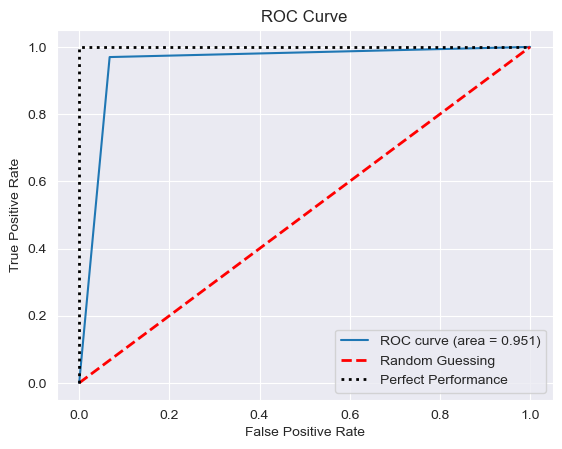

In [131]:
#plot the auc score
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_encoded)
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guessing')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', lw=2, color='black', label='Perfect Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

|      Model      |  Accuracy  | Precision |  Recall  |  F1 Score  |
|:---------------:|:----------:|:---------:|:--------:|:----------:|
| Random Forest   | 0.9511     | 0.9345    | 0.9698   | 0.9519     |
| Decision Tree   | 0.9309     | 0.9236    | 0.9391   | 0.9313     |
| Logistic Regression | 0.8545 | 0.8515    | 0.8577   | 0.8546     |

# Q4: Conclusion
Random Forest has the best performance among the three models. It has the highest accuracy, precision, recall and F1 score. The ROC AUC score is 0.9511, which is close to 1. The ROC curve is close to the top left corner, which means the model has a good performance. Therefore, Random Forest is the best model for this dataset.